# 02_Gradient-Based

In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
def load_imagenet_labels(labels_file):
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

imagenet_labels = load_imagenet_labels('data/ImageNetLabels.txt')

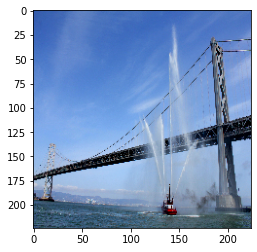

In [4]:
def read_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=(224, 224))
    return image

image = read_image('data/fireboat.jpg')
plt.imshow(image/255)

In [5]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    inputs = preprocess_input(image_batch)
    predictions = model(inputs)
    top_probs, top_idxs = tf.math.top_k(input=predictions, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_idxs[0], top_probs[0]

In [6]:
pred_label, pred_idx, pred_prob = top_k_predictions(image)
for label, idx, prob in zip(pred_label, pred_idx, pred_prob):
    print(f'{label} ({idx}): {prob:0.1%}')

fireboat (554): 98.6%
drilling platform (540): 0.3%
crane (517): 0.2%


In [7]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        probs = predictions[:, target_class_idx]
    return tape.gradient(probs, images)

## [1. Sensitivity Analysis (Simonyan et al. 14)](https://arxiv.org/abs/1312.6034)

In [8]:
image_batch = tf.expand_dims(image, 0)
inputs = preprocess_input(image_batch)
gradients = compute_gradients(
    images=inputs,
    target_class_idx=554)

attribution_mask = tf.reduce_sum(tf.math.abs(tf.squeeze(gradients)), axis=-1)

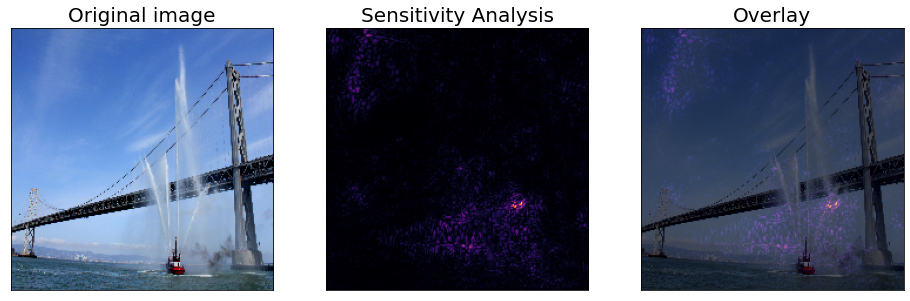

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Sensitivity Analysis', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

### 包成一個函數，方便呼叫

In [10]:
@tf.function
def vanilla_gradients(image,
                      target_class_idx):
    image_batch = tf.expand_dims(image, 0)
    inputs = preprocess_input(image_batch)
    gradients = compute_gradients(
        images=inputs,
        target_class_idx=target_class_idx)

    return tf.squeeze(gradients)

In [11]:
vg_attributions = vanilla_gradients(image=image,
                                    target_class_idx=554)

attribution_mask = tf.reduce_sum(tf.math.abs(vg_attributions), axis=-1)

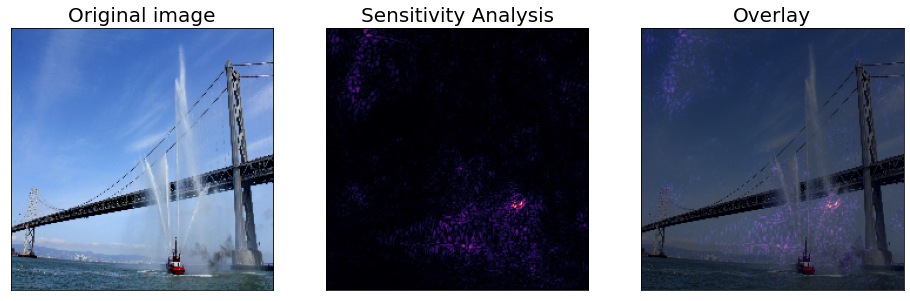

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Sensitivity Analysis', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

## [2. SmoothGrad (Smikov et al. 17)](https://arxiv.org/abs/1706.03825)

In [13]:
def generate_noisy_images(images, num_samples, noise):
    repeated_images = tf.repeat(images, num_samples, axis=0)
    noise = np.random.normal(0, noise, repeated_images.shape).astype(np.float32)
    return tf.clip_by_value(repeated_images + noise, 0, 255)

In [14]:
num_samples = 4
noise = 25
image_batch = tf.expand_dims(image, 0)
noisy_images = generate_noisy_images(image_batch, num_samples, noise)

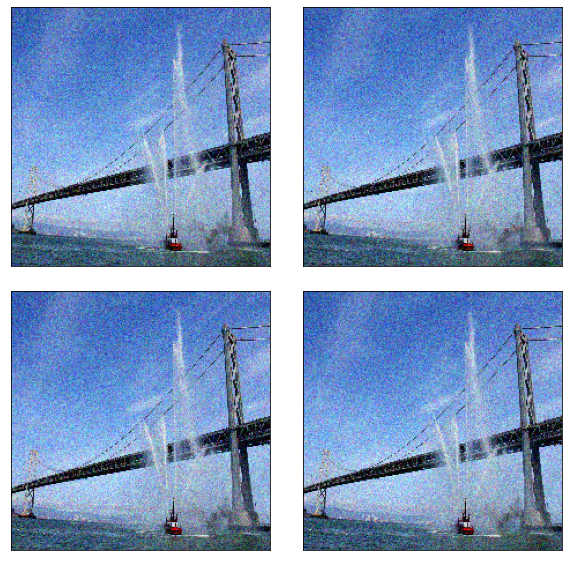

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(2):
    ax[0, i].imshow(noisy_images[i]/255)
    ax[1, i].imshow(noisy_images[i+2]/255)

In [16]:
inputs = preprocess_input(noisy_images)
gradients = compute_gradients(
    images=inputs,
    target_class_idx=554)

averaged_grads = tf.reduce_mean(gradients, axis=0)
attribution_mask = tf.reduce_sum(tf.math.abs(averaged_grads), axis=-1)

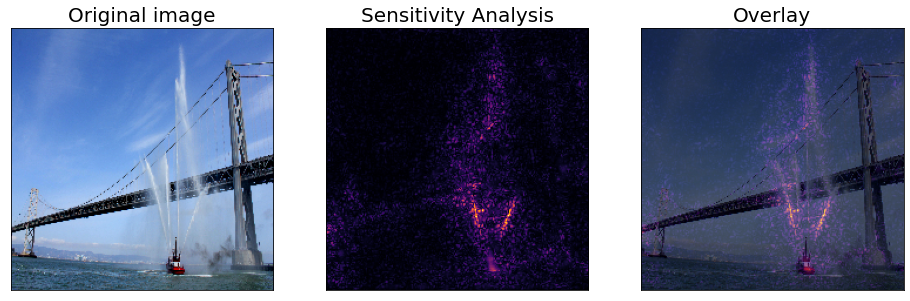

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Sensitivity Analysis', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

### 包成一個函數，方便呼叫

In [18]:
@tf.function
def smooth_gradients(image,
                     target_class_idx,
                     num_samples,
                     noise=1):
    
    image_batch = tf.expand_dims(image, 0)
    noisy_images = generate_noisy_images(image_batch, num_samples, noise)
    inputs = preprocess_input(noisy_images)

    gradients = compute_gradients(
        images=inputs,
        target_class_idx=target_class_idx)

    averaged_grads = tf.reduce_mean(gradients, axis=0)

    return tf.squeeze(averaged_grads)

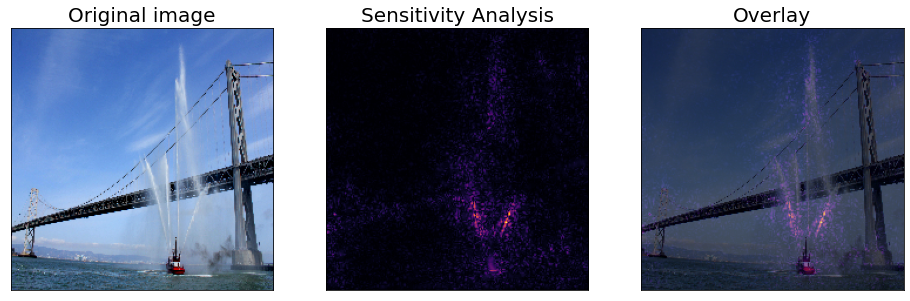

In [19]:
averaged_grads = smooth_gradients(image, target_class_idx=554, num_samples=4, noise=25)
attribution_mask = tf.reduce_sum(tf.math.abs(averaged_grads), axis=-1)

fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Sensitivity Analysis', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

## [3. Integrated Gradients (Sundararajan et al. 17)](https://arxiv.org/abs/1703.01365)

In [20]:
def f(x):
    """A simplified model function."""
    return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
    """A straight line path."""
    return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

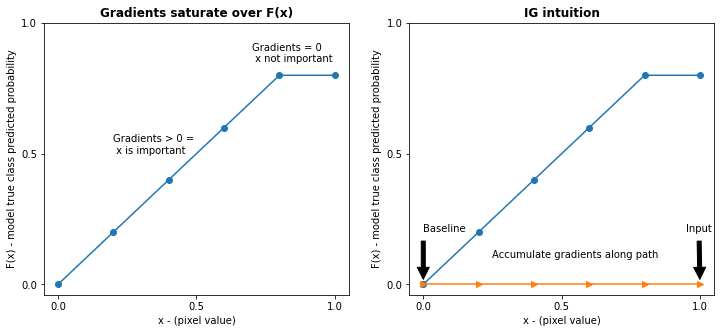

In [21]:
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show();

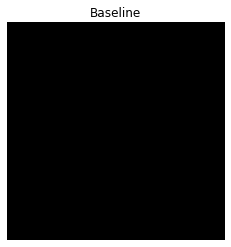

In [22]:
baseline = tf.zeros(shape=(224,224,3))

plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

### 從 basline 影像和原始影像間插值出多張影像

In [23]:
m_steps = 5
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) 

In [24]:
def interpolate_images(baseline,
                       image,
                       alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x + alphas_x * delta
    return images

In [25]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=image,
    alphas=alphas)

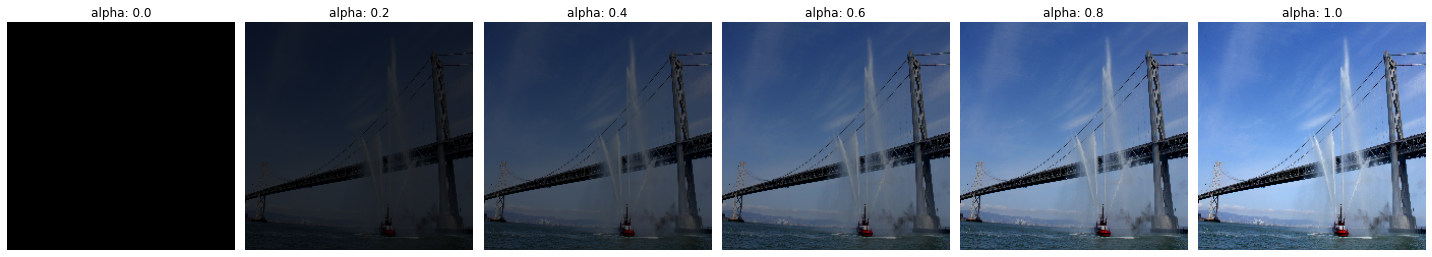

In [26]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas, interpolated_images):
    i += 1
    plt.subplot(1, len(alphas), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image/255)
    plt.axis('off')

plt.tight_layout();

### 計算他們各自的梯度

In [27]:
inputs = preprocess_input(interpolated_images)

path_gradients = compute_gradients(
    images=inputs,
    target_class_idx=554)

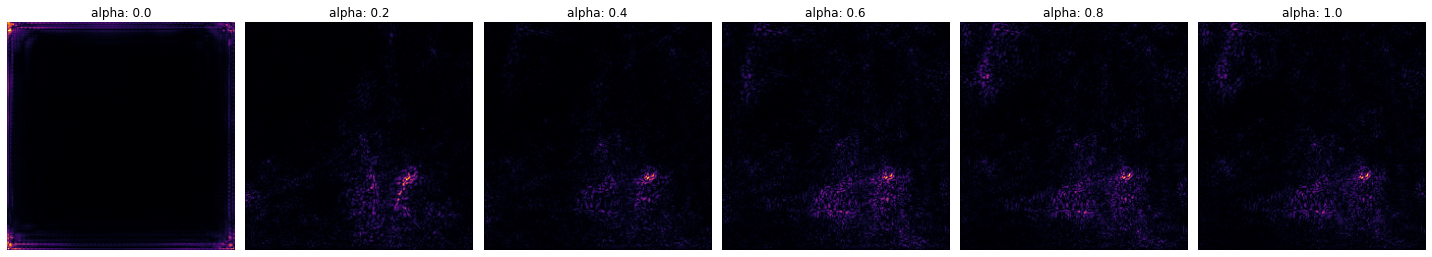

In [28]:
attribution_mask = tf.reduce_sum(tf.math.abs(path_gradients), axis=-1)

fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, attribution in zip(alphas, attribution_mask):
    i += 1
    plt.subplot(1, len(alphas), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(attribution, cmap=cm.inferno)
    plt.axis('off')

plt.tight_layout();

### 可視化梯度的變化情形

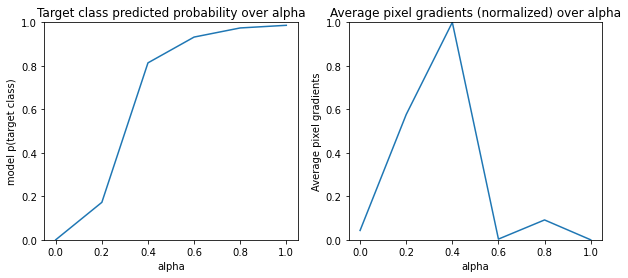

In [29]:
pred_proba = model(inputs)[:, 554]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

### 將梯度累積起來並乘以(原始影像-基線影像)
$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times \overbrace{\sum_{k=1}^{m}}^\text{Sum m local gradients}
\text{gradients(interpolated images)} \times \overbrace{\frac{1}{m}}^\text{Divide by m steps}$

In [30]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [31]:
ig = integral_approximation(
    gradients=path_gradients)

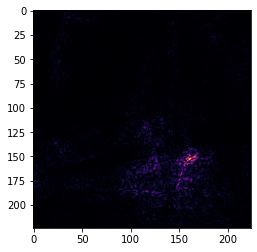

In [32]:
ig_attributions = (image - baseline) * ig
attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)
plt.imshow(attribution_mask, cmap=cm.inferno)

### 包成一個函數，方便呼叫

$IntegratedGrads^{approx}_{i}(x)::=\overbrace{(x_{i}-x'_{i})}^\text{5.}\times \overbrace{\sum_{k=1}^{m}}^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m}}^\text{1.}\times(x - x'))}^\text{2.}}^\text{3.}}{\partial x_{i}} \times \overbrace{\frac{1}{m}}^\text{4.}$

1. 生成出對應的插值 $\alpha=\frac{k}{m}$

2. 生成出多張插值影像：$\text{interpolated path inputs}=(x' + \alpha\times(x - x'))$

3. 計算各自的梯度值：$\text{gradients}=\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i}}$

4. 將梯度累積起來：$\text{integrated gradients}=\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$

5. 將梯度積分乘以(原始影像-基線影像)：$\text{attributions}=(x_{i}-x'_{i}) \times \text{integrated gradients}$. 

In [33]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
    # 1. Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Initialize TensorArray outside loop to collect gradients.    
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    
    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        # 2. Generate interpolated inputs between baseline and input.
        interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                           image=image,
                                                           alphas=alpha_batch)

        # 3. Compute gradients between model outputs and interpolated inputs.
        inputs = preprocess_input(interpolated_path_input_batch)
        gradient_batch = compute_gradients(images=inputs,
                                           target_class_idx=target_class_idx)
        
        # Write batch indices and gradients to extend TensorArray.
        gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    
  
    # Stack path gradients together row-wise into single tensor.
    total_gradients = gradient_batches.stack()

    # 4. Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)

    # 5. Scale integrated gradients with respect to input. 
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

In [34]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=image,
                                       target_class_idx=554,
                                       m_steps=5)

attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)

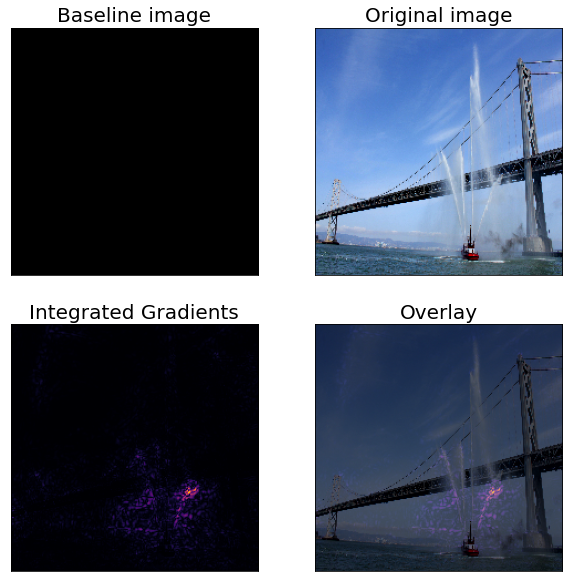

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(10, 10),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Baseline image', fontsize=20)
axs[0, 0].imshow(baseline)

axs[0, 1].set_title('Original image', fontsize=20)
axs[0, 1].imshow(image/255)

axs[1, 0].set_title('Integrated Gradients', fontsize=20)
axs[1, 0].imshow(attribution_mask, cmap=cm.inferno)

axs[1, 1].set_title('Overlay', fontsize=20)
axs[1, 1].imshow(attribution_mask, cmap=cm.inferno)
axs[1, 1].imshow(image/255, alpha=0.4)

### 練習時間：
#### 試試看用不同影像 (data/cat.jpeg) 來跑這三種方法。 
1. Sensitivity Analysis (Simonyan et al. 14): 更換 target_class_idx，看梯度有沒有關注在不同的地方。
2. SmoothGrad (Smikov et al. 17): 更換 num sample，看是不是越多 sample 噪音越少。
3. Integrated Gradients (Sundararajan et al. 17): 調整看看 m_steps，看看是不是越多解釋性越穩定。